# Music Recommendation System Evaluation (MagnaTagATune)

In this Notebook we are going to prepare MagnaTagATune dataset for recommendation and use it for toy recommendation systems. Before running this notebook generate a genre classifier model and download the 'Tag annotations', 'Similarity data' and the dataset. Link: http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset.

### Imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import utils as np_utils
from tensorflow.python.keras.layers import Layer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels
import matplotlib as plt
plt.use("Agg")
%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import time
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
import librosa as lb 
from scipy.io import wavfile
from scipy.spatial.distance import cosine as cos_distance
from sklearn.model_selection import train_test_split
import pandas as pd

### Preprocess Data

In [3]:
SR = 22050
N_FFT = 512
HOP_LENGTH = N_FFT // 2
N_MELS = 64 

In [4]:
def log_melspectrogram(data, log=True, plot=False, num='', genre=""):

    melspec = lb.feature.melspectrogram(y=data, hop_length = HOP_LENGTH, n_fft = N_FFT, n_mels = N_MELS)

    if log:
        melspec = lb.power_to_db(melspec**2)[:,1200:1373]
        
    if plot:
        melspec = melspec[np.newaxis, :]
        plt.imshow(melspec.reshape((melspec.shape[1],melspec.shape[2])))
        plt.savefig('melspec'+str(num)+'_'+str(genre)+'.png')

    return melspec

def batch_log_melspectrogram(data_list, log=True, plot=False):
    melspecs = np.asarray([log_melspectrogram(data_list[i],log=log,plot=plot) for i in range(len(data_list))])
    return melspecs

### Similarity Functions

In [5]:
def euclid(x, y):
    return np.sqrt(np.sum((x - y)**2, axis=1))

def cosine(x, y):
    num = np.sum(x*y, axis=1)
    denom = np.sqrt(np.dot(x, x.T))*np.diag(np.sqrt(np.dot(y, y.T)))
    
    return np.squeeze(1 - num/denom, axis=0).T

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

### Load Model 

In [6]:
model = load_model('music_classifier_v1.h5', compile=False) # Place here your genre classifier
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 173, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 171, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 169, 64)  18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 20, 56, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Prepare Data for Evaluation of Music Recommendation

In [7]:
# Get Annotations
annotations = pd.read_csv('annotations_final.csv', sep="\t")
annotations.head(2)

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


In [8]:

# Get Votes
comparisons = pd.read_csv('comparisons_final.csv', sep="\t")
comparisons.head(3)

,clip1_id,clip2_id,clip3_id,clip1_numvotes,clip2_numvotes,clip3_numvotes,clip1_mp3_path,clip2_mp3_path,clip3_mp3_path
0,42344,52148,53079,3,1,6,8/jacob_heringman-josquin_des_prez_lute_settin...,4/tim_rayborn-the_path_beyond-14-taqsim_ud-175...,9/the_wretch-ambulatory-15-release-146-175.mp3
1,44925,17654,56325,2,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...,8/hybris-the_first_words-04-final_trust-146-17...,9/the_strap_ons-geeking_crime-20-pimps-59-88.mp3
2,25699,2619,15184,0,0,2,b/philharmonia_baroque-beethoven_symphonies_no...,4/jay_kishor-the_color_of_night-01-malkauns-10...,4/seth_carlin-schubert__works_for_solo_fortepi...


In [9]:
# Extract most similar playlists
sum_numvotes = 1
clip1_numvotes = comparisons['clip1_numvotes']
clip2_numvotes = comparisons['clip2_numvotes']
clip3_numvotes = comparisons['clip3_numvotes']
clip_numvotes = clip1_numvotes + clip2_numvotes + clip3_numvotes  
similar_playlists_idx = np.squeeze(np.where(clip_numvotes<=sum_numvotes))
dissimilar_playlists_idx = np.squeeze(np.where(clip_numvotes>sum_numvotes))
comparisons.drop(list(dissimilar_playlists_idx), inplace=True)
similar_playlists = comparisons

In [10]:
# Load audio files
songs = []
ids = []

for i in range(1,4):
    j=0
    for path in similar_playlists['clip' + str(i) + '_mp3_path']:
        song, _ = lb.load('mp3/'+ path, sr=None)
        songs.append(song)
        ids.append(list(similar_playlists['clip' + str(i) + '_id'])[j])
        j+=1

In [11]:
# Mel-spectrograms
data = batch_log_melspectrogram(songs)

In [12]:
# Predict the genres for the data
corpus_predictions = model.predict(data[:, :, :, np.newaxis])

In [15]:
# Distribution of Data
distribution = []

for i in range(len(similar_playlists)):
    idx = corpus_predictions[i].argmax()
    one_hot = np.zeros(10)
    one_hot[idx] = 1
    distribution.append(one_hot)

# Blues, Classical, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock
print(np.asarray(distribution).sum(axis=0))

[ 6.  9. 13.  3.  1.  0.  6. 19.  3.  8.]


## Similarity based on last FC-Layer

In [16]:
# Predict only for column clip1_id
# Accuracy: Top-5 Accuracy
predicted_playlist_cosine = []
i=0
for x in data[:len(similar_playlists)]:
    tmp_predictions = np.delete(corpus_predictions, i, axis=0)
    tmp_ids = np.delete(ids, i)
    test_prediction = model.predict(x[np.newaxis, :, :, np.newaxis], steps=1)
    cosine_vec = cosine(test_prediction, tmp_predictions)
    predicted_playlist_cosine.append((tmp_ids[cosine_vec.argsort()[0]], 
                                      tmp_ids[cosine_vec.argsort()[1]], 
                                      tmp_ids[cosine_vec.argsort()[2]],
                                      tmp_ids[cosine_vec.argsort()[3]],
                                      tmp_ids[cosine_vec.argsort()[4]]))
    i+=1

In [17]:
score = 0
target_playlist = list(np.asarray(comparisons[[ 'clip2_id', 'clip3_id']]))

for i in range(len(predicted_playlist_cosine)):
    if (target_playlist[i][0] in predicted_playlist_cosine[i]) or (target_playlist[i][1] in predicted_playlist_cosine[i]):
        score+=1
        
top5_accuracy = score /len(similar_playlists) #if predicted playlist contains all songs in target playlist
print(top5_accuracy)

0.058823529411764705


## Data-Driven  Approach

### Prepare data

In [18]:
val_size = round(len(similar_playlists)*0.1)
test_size = round(len(similar_playlists)*0.1)

train_set = corpus_predictions[:len(similar_playlists)-test_size-val_size][:, :, np.newaxis]
train_size = len(train_set)
val_set = corpus_predictions[len(similar_playlists)-test_size-val_size:len(similar_playlists)-test_size][:, :, np.newaxis]

test_set = corpus_predictions[len(similar_playlists)-test_size:len(similar_playlists)][:, :, np.newaxis]

data = np.concatenate((corpus_predictions[:len(similar_playlists)],
                    corpus_predictions[len(similar_playlists):(len(similar_playlists)*2)]), axis=1)[:, :, np.newaxis]

x_test = data[::-1][:test_size]

x = np.delete(data[::-1], list(range(test_size)), axis=0 )

In [20]:
# Ground Truth: Jaccard Similarity
annotations = pd.read_csv('annotations_final.csv', sep="\t")
annotations = np.asarray(annotations.drop('mp3_path', axis=1))
clip1_tags = annotations[[list(annotations[:,0]).index(id) for id in similar_playlists['clip1_id']]][:, 1:]
clip2_tags = annotations[[list(annotations[:,0]).index(id) for id in similar_playlists['clip2_id']]][:, 1:]

jaccard = []

for i in range(len(similar_playlists)):
    jaccard.append(jaccard_similarity(clip1_tags[i], clip2_tags[i]))
truths = np.asarray(jaccard)[:, np.newaxis]#, np.newaxis]

y_test = truths[::-1][:test_size]

y = np.delete(truths[::-1], list(range(test_size)), axis=0 )

In [21]:
#split data
x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.1, shuffle=False)

### FC: Network Architektur

In [26]:
reg = 0.001
drop = 0.5

recommendation_model = Sequential()
recommendation_model.add(Dense(20, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(reg), input_shape=(20, 1)))
recommendation_model.add(Dropout(drop))
recommendation_model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(reg), use_bias=True))
recommendation_model.add(Dropout(drop))
recommendation_model.add(Flatten(data_format=None))
recommendation_model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg), use_bias=True))

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

recommendation_model.compile(loss=tensorflow.keras.losses.mean_squared_error,
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy', mean_pred]) #accuracy does not have any meaning 
recommendation_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20, 20)            40        
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 20, 30)            630       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 601       
Total params: 1,271
Trainable params: 1,271
Non-trainable params: 0
____________________________________________________

### Fit/Train model and evaluate

In [27]:
batch_size = 4
epochs = 250
start = time.time()
history = recommendation_model.fit(x=x_tr,
                                   y=y_tr,
                                   validation_data=(x_val, y_val),
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   verbose=0,
                                   shuffle=True)

print("\n")
recommendation_model.evaluate(x_val, y_val)
print("\nTraining took ", time.time()-start, "seconds")



7/7 [==============================] - 0s 330us/sample - loss: 0.0593 - accuracy: 0.7143 - mean_pred: 0.8973

Training took  11.357728481292725 seconds


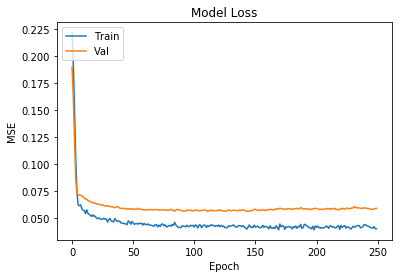

In [28]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#NOTE: Dropout makes the training loss >= test loss for every epoch

### Evaluation

#### MSE

In [29]:
predictions = recommendation_model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print(mse)

0.030126414936776463


### Save model

In [30]:
recommendation_model.save('recommendation_model.h5')